In [1]:
from py2cytoscape.data.cyrest_client import CyRestClient

from IPython.display import Image

import networkx as nx
import pandas as pd

import pymaid

rm = pymaid.CatmaidInstance('url', 'http_user', 'http_pw', 'token')

print('pymaid version:', pymaid.__version__)

INFO  : Global CATMAID instance set. (pymaid)


pymaid version: 0.89


In [2]:
# Fire up the cytoscape interface - this will throw an error if no connection is found (e.g. if Cytoscape is not running)
cy = CyRestClient()

# Clear running session (= delete existing networks and views)
cy.session.delete()

In [3]:
adj = pymaid.adjacency_matrix('annotation:MBON a2sc', 'annotation:PD2a1/b1')
g = pymaid.network2nx(adj)

INFO  : Found 2 skeletons with matching annotation(s) (pymaid)
INFO  : Found 7 skeletons with matching annotation(s) (pymaid)
INFO  : Retrieving and filtering connectivity... (pymaid)
INFO  : Finished! (pymaid)


In [4]:
# By default, nodes use their skeleton ID as unique identifier and have their neuron name attached as custom attribute
print('Example node:', g.node['346114'] )

# Edges only have a 'weight' attribute
print('Example edge:', g.edges['346114', '2205218'])

Example node: {'neuron_name': 346114}
Example edge: {'weight': 18.0}


In [5]:
# This generates the network in Cytoscape
n = cy.network.create_from_networkx(g)

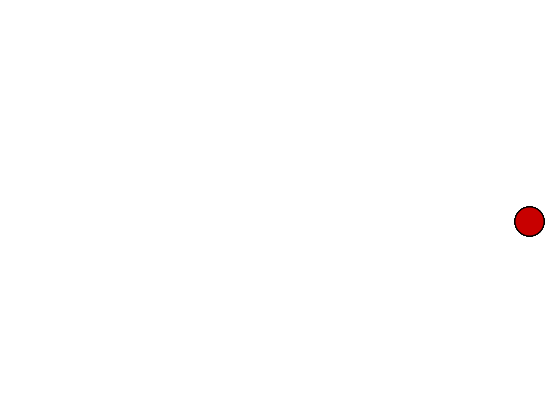

In [6]:
# We can get an image from the current layout and show in this notebook:
Image(n.get_png(height=400))

In [7]:
# Get a list of available layouts:
cy.layout.get_all()

['attribute-circle',
 'stacked-node-layout',
 'degree-circle',
 'circular',
 'attributes-layout',
 'kamada-kawai',
 'force-directed',
 'cose',
 'grid',
 'hierarchical',
 'fruchterman-rheingold',
 'isom',
 'force-directed-cl']

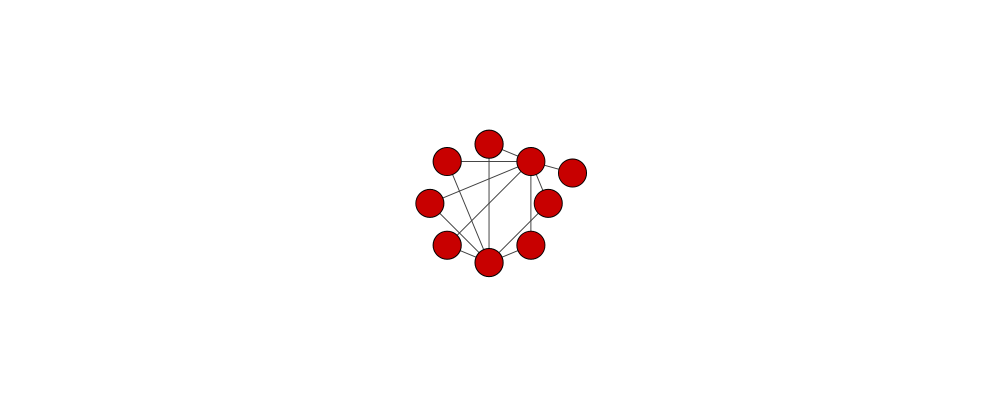

In [8]:
# Apply a layout
cy.layout.apply(name='circular', network=n)

# Plot again
Image(n.get_png(height=400))

In [9]:
# This will either retrieve the style "my_style" or generate one if it doesn't already exists
#  You can get a list of available styles using cy.style.get_all()
s = cy.style.create('my_style')

In [10]:
# To get a list of available parameters:
pd.Series(cy.style.vps.get_all())

COMPOUND_NODE_PADDING                                   Padding (Compound Node)
COMPOUND_NODE_SHAPE                                       Shape (Compound Node)
DING_RENDERING_ENGINE_ROOT            Ding Rndering Engine Root Visual Property
EDGE                                                       Edge Visual Property
EDGE_BEND                                                             Edge Bend
EDGE_CURVED                                                         Edge Curved
EDGE_LABEL                                                           Edge Label
EDGE_LABEL_COLOR                                               Edge Label Color
EDGE_LABEL_FONT_FACE                                       Edge Label Font Face
EDGE_LABEL_FONT_SIZE                                       Edge Label Font Size
EDGE_LABEL_TRANSPARENCY                                 Edge Label Transparency
EDGE_LABEL_WIDTH                                               Edge Label Width
EDGE_LINE_TYPE                          

In [11]:
# Define our own settings
custom_settings = dict(       

        NODE_FILL_COLOR= '#FEC44F',
        NODE_SIZE= 18,
        NODE_BORDER_WIDTH= 7,
        NODE_BORDER_COLOR= '#999999',
        NODE_LABEL_COLOR= '#555555',
        NODE_LABEL_FONT_SIZE= 14,
        NODE_LABEL_POSITION= 'S,NW,c,0.00,3.00',

        EDGE_WIDTH= 2,
        EDGE_TRANSPARENCY= 100,
        EDGE_UNSELECTED_PAINT= '#CCCCCC',
        EDGE_STROKE_UNSELECTED_PAINT= '#333333',
        EDGE_TARGET_ARROW_SHAPE= 'DELTA',

        NETWORK_BACKGROUND_PAINT= '#FFFFFF',
    )

# Apply settings to our style
s.update_defaults(custom_settings)

In [12]:
# Set the label to use the "neuron_name" column:
s.create_passthrough_mapping(column='neuron_name', vp='NODE_LABEL', col_type='String')

# Make edge width use the "weight" column and have it scale with 1/3 of the number of synapses
max_edge_weight = n.get_edge_column('weight').max()
s.create_continuous_mapping(column='weight', vp='EDGE_WIDTH', col_type='Double',
                            points=[{'equal': '1.0', 'greater': '1.0', 'lesser': '1.0', 'value': 1.0},
                                    {'equal': max_edge_weight/3, 'greater': 1.0, 'lesser': max_edge_weight/3, 'value': max_edge_weight}]
                            )

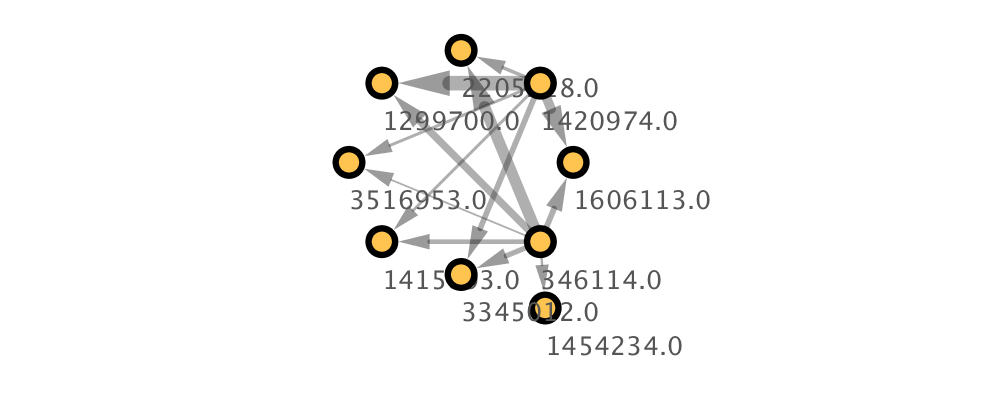

In [13]:
# Apply style and render again
cy.style.apply(s, n)

# Plot again
Image(n.get_png(height=400))

In [14]:
neuron_type = {'PD2a' : pymaid.get_skids_by_annotation('PD2a1/b1'),
               'a2sc' : pymaid.get_skids_by_annotation('MBON a2sc')}
neuron_type

INFO  : Found 7 skeletons with matching annotation(s) (pymaid)
INFO  : Found 2 skeletons with matching annotation(s) (pymaid)


{'PD2a': ['1454234',
  '2205218',
  '3345012',
  '1299700',
  '3516953',
  '1415893',
  '1606113'],
 'a2sc': ['346114', '1420974']}

In [15]:
adj_grp = pymaid.group_matrix(adj, col_groups=neuron_type, row_groups=neuron_type)
adj_grp.head()

col_groups,PD2a
row_groups,
a2sc,110.0


In [16]:
# Generate a NetworkX graph from the adjaceny matrix
g = pymaid.network2nx(adj_grp)

In [17]:
# Let's add the number of neurons in each "compound" node 
attrs = { g : { 'n_neurons' : len(v) } for g,v in neuron_type.items()}

# Add attributes
nx.set_node_attributes(g, attrs)

g.nodes['a2sc']

{'n_neurons': 2}

In [18]:
# Clear and Add network
cy.session.delete()

# This generates the network in Cytoscape
n = cy.network.create_from_networkx(g)

In [19]:
# Apply a layout
cy.layout.apply(name='force-directed-cl', network=n)

In [20]:
# Get our style again (remember we've deleted the session!)
s = cy.style.create('my_style')
s.update_defaults(custom_settings)

# Set the label to use the "name" column:
s.create_passthrough_mapping(column='name', vp='NODE_LABEL', col_type='String')

# Make edge width use the "weight" column and have it scale with 1/3 of the number of synapses
max_edge_weight = n.get_edge_column('weight').max()
s.create_continuous_mapping(column='weight', vp='EDGE_WIDTH', col_type='Double',
                            points=[{'equal': '1.0', 'greater': '1.0', 'lesser': '1.0', 'value': 1.0},
                                    {'equal': max_edge_weight/8, 'greater': 1.0, 'lesser': max_edge_weight/8, 'value': max_edge_weight}]
                            )

# Add node size mapping to our style
max_neurons = n.get_node_column('n_neurons').max()
min_size = 10
max_size = 30
s.create_continuous_mapping(column='n_neurons', vp='NODE_SIZE', col_type='Double',
                            points=[{'equal': min_size, 'greater': min_size, 'lesser': '1.0', 'value': 1.0},
                                    {'equal': max_size, 'greater': 1.0, 'lesser': max_size, 'value': max_neurons}]
                            )

# Apply style
cy.style.apply(s, n)

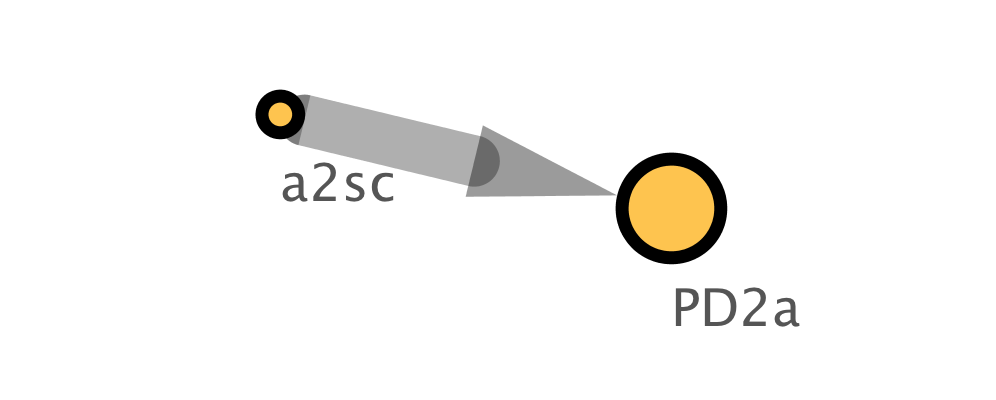

In [21]:
# Plot again
Image(n.get_png(height=400))

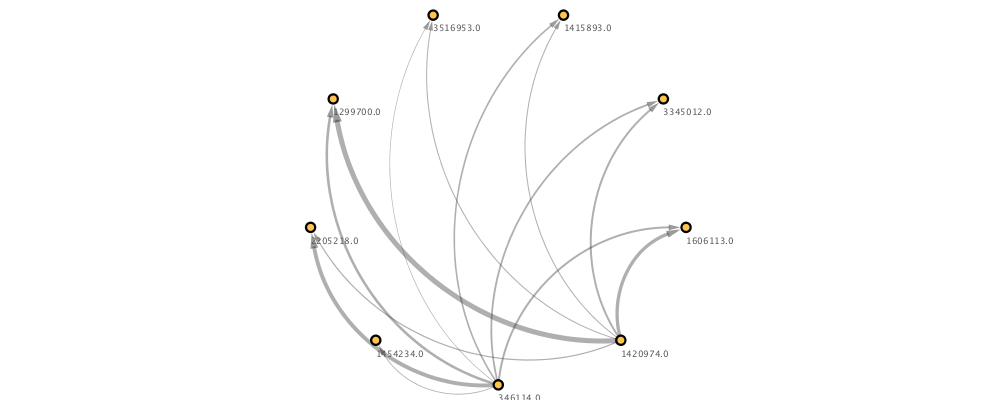

In [22]:
from pymaid import cytoscape as cs

g = pymaid.network2nx(adj)

n = cs.generate_network(g, clear_session=True)

# Plot again
Image(n.get_png(height=400))

In [23]:
from pymaid import cytoscape as cs

cs.watch_network('annotation:glomerulus DA1',
                 n_circles=1,   # increase to >1 for indirect partners or set to 0 for seed neurons-only
                 min_pre=5,     # 5 synapse minimum from a seed neuron to be included
                 min_post=-1,   # set threshold to -1 to exclude upstream partners
                 sleep=5,       # sleep for 5s after each update
                )

In [24]:
# Same set up as above but we collapse all excitatory DA1 PNs into a single group
cs.watch_network('annotation:glomerulus DA1',
                 n_circles=1,   
                 min_pre=5,     
                 min_post=-1,   
                 sleep=5,
                 group_by={'exc DA1': pymaid.get_skids_by_annotation('glomerulus DA1 right excitatory')}
                )